# Loading the Dataset

In [1]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("Lichess/tournament-chess-games")
ds

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/65 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle', 'WhiteFideId', 'BlackFideId', 'WhiteElo', 'BlackElo', 'UTCDate', 'UTCTime', 'ECO', 'Opening', 'Termination', 'TimeControl', 'Board', 'Variant', 'StudyName', 'ChapterName', 'BroadcastName', 'BroadcastURL', 'GameURL', 'movetext'],
        num_rows: 733234
    })
})

In [2]:
columns = list(ds['train'].features.keys())
columns.remove('WhiteElo')
columns.remove('BlackElo')
columns.remove('movetext')
columns.remove('Variant')

In [3]:
ds['train'] = ds['train'].remove_columns(columns)
ds

DatasetDict({
    train: Dataset({
        features: ['WhiteElo', 'BlackElo', 'Variant', 'movetext'],
        num_rows: 733234
    })
})

# Processing the Dataset

### Selecting a Subset

In [4]:
import pandas as pd

df = pd.DataFrame(ds['train'][:])
df.dropna(how='any', inplace=True)
df

,WhiteElo,BlackElo,Variant,movetext
0,2578.0,2584.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:43] } 1... Nf6...
1,2584.0,2578.0,Standard,1. e4 { [%eval 0.24] [%clk 1:30:54] } 1... e5 ...
2,2578.0,2584.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:40] } 1... Nf6...
3,2584.0,2578.0,Standard,1. d4 { [%eval 0.25] [%clk 1:30:56] } 1... d5 ...
4,2578.0,2584.0,Standard,1. c4 { [%eval 0.16] [%clk 1:30:49] } 1... Nf6...
...,...,...,...,...
733229,1979.0,1874.0,Standard,1. d4 { [%eval 0.17] [%clk 1:30:59] } 1... Nf6...
733230,1951.0,1810.0,Standard,1. e4 { [%eval 0.18] [%clk 1:30:57] } 1... c5 ...
733231,1825.0,1948.0,Standard,1. e4 { [%eval 0.18] [%clk 1:30:25] } 1... c6 ...
733232,1758.0,1940.0,Standard,1. d4 { [%eval 0.17] [%clk 1:30:57] } 1... d5 ...


In [5]:
df.describe()

,WhiteElo,BlackElo
count,5.455570e+05,5.455570e+05
mean,2.076021e+03,2.080754e+03
std,7.221848e+03,1.018806e+04
min,0.000000e+00,0.000000e+00
25%,1.831000e+03,1.828000e+03
50%,2.120000e+03,2.116000e+03
75%,2.384000e+03,2.382000e+03
max,5.324491e+06,5.327130e+06


In [6]:
idx = df['WhiteElo'] >= 2500
print(f'Percentage of gamse with (WhiteElolen >= 2000): {(len(df[idx]) / len(df)):.2%}')

Percentage of gamse with (WhiteElolen >= 2000): 14.15%


In [7]:
df = df[df['Variant'] == 'Standard']
og_len = len(df)
df = df[df['WhiteElo'] >= 2500] 
df = df[df['BlackElo'] >= 2500]
print(f'Percentage of remaining dataset: {len(df) / og_len:.2%}')

Percentage of remaining dataset: 8.19%


In [8]:
df = df.drop(columns=['Variant', 'WhiteElo', 'BlackElo'])

In [9]:
df.loc[0]

movetext    1. d4 { [%eval 0.25] [%clk 1:30:43] } 1... Nf6...
Name: 0, dtype: object

### Transform movetext to Standard PGN

In [10]:
import re

def clean_movetext(row):
    text = row['movetext']
    cleaned = re.sub(r"\{.*?\}", "", text) 
    cleaned = re.sub(r"[\?!]+", "", cleaned)
    cleaned = re.sub(r"\d+\.\.\.", "", cleaned)
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    
    return cleaned


In [11]:
df['movetext'] = df.apply(clean_movetext, axis=1)
df

,movetext
0,1. d4 Nf6 2. c4 e6 3. Nf3 d5 4. Nc3 Be7 5. g3 ...
1,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nf6 4. O-O Nxe4 5. ...
2,1. d4 Nf6 2. c4 e6 3. Nf3 d5 4. Nc3 c5 5. cxd5...
3,1. d4 d5 2. c4 c6 3. Nf3 Nf6 4. Nc3 dxc4 5. a4...
4,1. c4 Nf6 2. Nc3 e6 3. e4 d5 4. cxd5 exd5 5. e...
...,...
733182,1. d4 d6 2. Nf3 Nf6 3. g3 g6 4. Bg2 Bg7 5. c4 ...
733183,1. e4 c5 2. Nf3 e6 3. d3 Nc6 4. g3 Nf6 5. Bg2 ...
733196,1. Nf3 d5 2. c4 e6 3. d4 Nf6 4. Nc3 a6 5. cxd5...
733197,1. e4 c6 2. d4 d5 3. exd5 cxd5 4. Bd3 Nc6 5. c...


### Game Lenghth Distribution

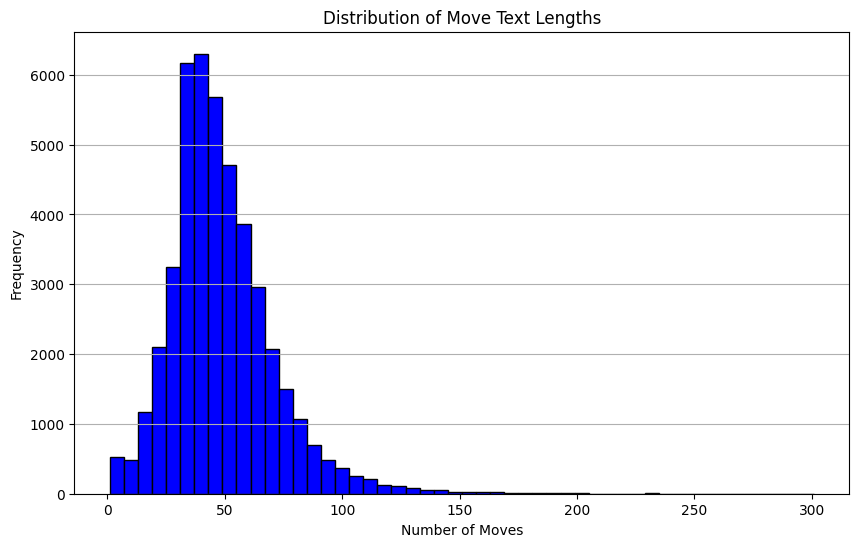

In [12]:
import matplotlib.pyplot as plt

df['length'] = df['movetext'].apply(lambda x: len(x.split('.')))

plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Move Text Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

In [13]:
df.drop(columns=['length'], inplace=True)

### Splitting the Dataset

In [14]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.25, random_state=42)
train_df

,movetext
311844,1. e4 c5 2. Nf3 Nc6 3. Bb5 e6 4. O-O Nge7 5. R...
116088,1. d4 Nf6 2. Bg5 d5 3. e3 c5 4. c3 cxd4 5. exd...
370202,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
492202,1. c4 c6 2. Nf3 d5 3. d4 Nf6 4. Nc3 e6 5. g3 d...
579558,1. d4 d5 2. c4 e6 3. Nc3 Nf6 4. Bg5 c5 5. cxd5...
...,...
62870,1. d4 d5 2. c4 e6 3. Nc3 c5 4. cxd5 cxd4 5. Qa...
105754,1. e4 c6 2. d4 d5 3. e5 Bf5 4. Nf3 e6 5. Be2 c...
585993,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. c3 Nf6 5. d3...
2626,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...


### Transforming the Dataset back

In [15]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
ds = DatasetDict({
    'train': train_ds,
    'valid': valid_ds
})

### Extracting Individual Turns from each Game

In [ ]:
import chess
import chess.pgn

def extract_turns(row):
    positions = []
    moves = []

    text = row['movetext'][0]
    with open('tmp.pgn', 'w') as f:
        f.write(text)

   
    pgn = open("tmp.pgn")
    game = chess.pgn.read_game(pgn)
    if game.errors:
        return {"positions": [], "moves": []}
    else:
        pass
    
    board = game.board()

    for move in game.mainline_moves():
        if board.turn:
            pos = 'WHITE'
            if chess.Move.from_uci("e1g1") in board.legal_moves:
                pos = pos + ' ' + 'KINGSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_KINGSIDE_CASTLE'
            if chess.Move.from_uci("e1c1") in board.legal_moves:
                pos = pos + ' ' + 'QUEENSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_QUEENSIDE_CASTLE'

        else:
            pos = 'BLACK'

            if chess.Move.from_uci("e8g8") in board.legal_moves:
                pos = pos + ' ' + 'KINGSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_KINGSIDE_CASTLE'
            if chess.Move.from_uci("e8c8") in board.legal_moves:
                pos = pos + ' ' + 'QUEENSIDE_CASTLE'
            else:
                pos = pos + ' ' + 'NO_QUEENSIDE_CASTLE'
        
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece is not None:
                pos = pos + ' ' + chess.square_name(square) + '_' + piece.symbol()
            else:
                pos = pos + ' ' + chess.square_name(square) + '_' + 'EMPTY'

        board.push(move)
        positions.append(pos)
        moves.append(move.uci())


    return {'positions': positions, 'moves': moves}

ds = ds.map(extract_turns, batched=True, batch_size=1, remove_columns=['movetext', '__index_level_0__'])
    

In [25]:
ds

DatasetDict({
    train: Dataset({
        features: ['positions', 'moves'],
        num_rows: 3063989
    })
    valid: Dataset({
        features: ['positions', 'moves'],
        num_rows: 1019420
    })
})

### Pushing to HuggingFace

In [27]:
from huggingface_hub import login

login()

In [28]:
repo_id = "noor-zalouk/tournament-chess-games-modified"
ds.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/766 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         |  622kB / 39.6MB            

Creating parquet from Arrow format:   0%|          | 0/766 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         |  623kB / 39.6MB            

Creating parquet from Arrow format:   0%|          | 0/766 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         |  623kB / 39.7MB            

Creating parquet from Arrow format:   0%|          | 0/766 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         |  621kB / 39.7MB            

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/510 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         |  622kB / 26.4MB            

Creating parquet from Arrow format:   0%|          | 0/510 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         |  622kB / 26.4MB            

CommitInfo(commit_url='https://huggingface.co/datasets/noor-zalouk/tournament-chess-games-modified/commit/20c8af941dc4fe5907c96fa410f69aca19640ca5', commit_message='Upload dataset', commit_description='', oid='20c8af941dc4fe5907c96fa410f69aca19640ca5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/noor-zalouk/tournament-chess-games-modified', endpoint='https://huggingface.co', repo_type='dataset', repo_id='noor-zalouk/tournament-chess-games-modified'), pr_revision=None, pr_num=None)